In [3]:
import numpy
import scipy
import pickle
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn
import matplotlib.pyplot as plt
import datetime
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import warnings
import json
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

df = pd.read_csv('all.csv')

In [4]:
def add_date_columns(df):
    date_columns = ['X32', 'X33', 'X39']
    for column in date_columns:
        df[column] = pd.to_datetime(df[column], format='%m/%d/%Y')
        df[column+'.year'] = df[column].dt.year
        df[column+'.month'] = df[column].dt.month
        df[column+'.dayofmonth'] = df[column].dt.day
    return df

def preprocess(df):
    
    df = add_date_columns(df)
    df = df.drop(['XID', 'X32', 'X33', 'X42', 'X39'], axis=1)
    return df

def preprocess_final(df):
    
    df = add_date_columns(df)
    df = df.drop(['X32', 'X33', 'X42', 'X39'], axis=1)
    return df



def encode(df):
    for col in df.columns:
        if df[col].dtype == "object":
            le = LabelEncoder()
            df_list = list(df[col].values.astype(str))
            le.fit(df_list)
            df[col] = le.transform(df_list)
    return df

def print_info(X, Y, probability):
    if probability is None:
        print("ROC curve, precision recall curve and average precision are not accurate")
        probability = Y
    false_positive_rate, true_positive_rate, threshold = roc_curve(X, probability)
    precision, recall, threshold = precision_recall_curve(X, probability)
    plt.plot(false_positive_rate, true_positive_rate, color = 'darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(false_positive_rate, true_positive_rate))
    plt.plot([0,1],[0,1],'g--')
    plt.xlabel('False_positive_rate')
    plt.ylabel('True_positive_rate')
    legend = plt.legend(fontsize='x-large')
    plt.show()
    plt.plot(recall, precision, color = 'darkorange', label="Precision Recall curve ")
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    legend = plt.legend(fontsize='x-large')
    plt.show()
    tn,fp,fn,tp=confusion_matrix(X, Y).ravel()
    precision, recall, fscore, support = precision_recall_fscore_support(X, Y, average='binary')
    APS=average_precision_score(X, probability)
    AUC_FTPR=auc(false_positive_rate, true_positive_rate)
    print("(tn, fp, fn, tp) = ", confusion_matrix(X, Y).ravel())
    print("(precision, recall, fscore, support) = ", precision_recall_fscore_support(X, Y, average='binary'))
    print("Average precision score = ", average_precision_score(X, probability))
    print("Area Under Curve for fpr and tpr = ", auc(false_positive_rate, true_positive_rate))
    return [precision, recall, fscore, APS, AUC_FTPR]

df = preprocess(df)
df = encode(df)
df.fillna(0,inplace=True)
train_df = df.copy()

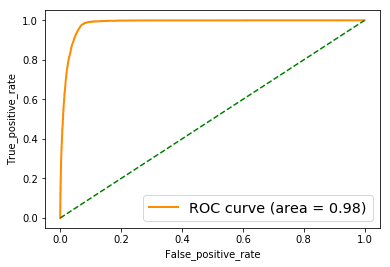

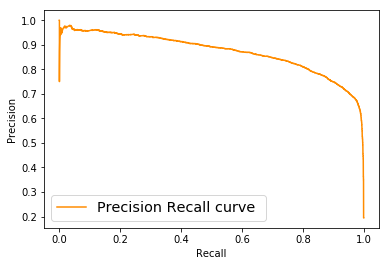

(tn, fp, fn, tp) =  [44152  2242   577  6277]
(precision, recall, fscore, support) =  (0.7368235708416481, 0.915815582141815, 0.8166265530475509, None)
Average precision score =  0.8724067775261157
Area Under Curve for fpr and tpr =  0.9832511351906374


[0.7368235708416481,
 0.915815582141815,
 0.8166265530475509,
 0.8724067775261157,
 0.9832511351906374]

In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

Y = train_df['Mailing Received']
X = train_df.drop(['Mailing Received','Mailing Responded'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100,stratify=Y)

sm = SMOTE(random_state=2)
X_train,y_train = sm.fit_sample(X_train,y_train)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

xgb1 = XGBClassifier(learning_rate=0.1,max_depth=10,scale_pos_weight = 1.8).fit(X_train, y_train)

predictions = xgb1.predict(X_test)
predictions_proba = xgb1.predict_proba(X_test)[:,1]
print_info(y_test, predictions, predictions_proba)

In [6]:
predictions = xgb1.predict(X.values)
train_df['49_20']=predictions
train_df[train_df['49_20']==1][train_df['Mailing Responded']==1]['Mailing Responded'].count()

44

In [7]:
# STAGE 2

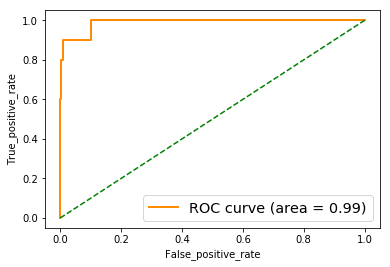

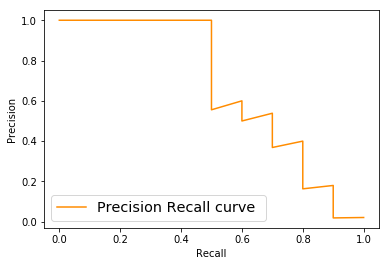

(tn, fp, fn, tp) =  [4558    2    5    5]
(precision, recall, fscore, support) =  (0.7142857142857143, 0.5, 0.588235294117647, None)
Average precision score =  0.673942589904854
Area Under Curve for fpr and tpr =  0.9883771929824562


[0.7142857142857143,
 0.5,
 0.588235294117647,
 0.673942589904854,
 0.9883771929824562]

In [10]:
# Read the data again for predicting the 50th column
df = pd.read_csv('all.csv')
df = preprocess(df)
df = encode(df)
df = df[df['Mailing Received'] == 1]
df.fillna(0,inplace=True)

# Code for Xgboost to predict Mailing Responded Column

Y = df['Mailing Responded']
X = df.drop(['Mailing Responded','Mailing Received'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=2)
X_train,y_train = sm.fit_sample(X_train,y_train)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

xgb2 = XGBClassifier(learning_rate=0.2, depth = 5, scale_pos_weight = 1).fit(X_train,y_train)
predictions = xgb2.predict(X_test)
predictions_proba = xgb2.predict_proba(X_test)[:,1]
print_info(y_test, predictions, predictions_proba)

In [14]:
# FINAL STAGE - predicting 49 and 50


In [15]:
df = pd.read_csv('5848768414_2.csv')
df = preprocess_final(df)
df = encode(df)
df.fillna(0,inplace=True)

df_processed = df.copy()

submission_df = df['XID'].copy()
submission_df = pd.DataFrame(submission_df)
df.drop(['XID'], axis=1,inplace = True)

df = sc.transform(df)
submission_df['Mailing Received'] = xgb1.predict(df)
submission_df['Mailing Received Proba'] = xgb1.predict_proba(df)[:,1]

In [16]:
df = df_processed.copy()

df['Mailing Received'] = submission_df["Mailing Received"].copy()
df = df[df["Mailing Received"]==1]

submission_50_df = df['XID'].copy()
submission_50_df = pd.DataFrame(submission_50_df)
df.drop(['XID', 'Mailing Received'], axis=1,inplace = True)

In [17]:
df = sc.transform(df)
submission_50_df["Mailing Responded"] = xgb2.predict(df)
submission_50_df["Mailing Responded Proba"] = xgb2.predict_proba(df)[:,1]

In [18]:
submission_50_df["Mailing Responded"].value_counts()

0    36720
1      297
Name: Mailing Responded, dtype: int64

In [19]:
submission_final = submission_df.set_index('XID').join(submission_50_df.set_index('XID'))
submission_final.fillna(0,inplace=True)
submission_final.to_csv('submission.csv', index=False)



# Conclusion

XGB Classifier gave better results